# Part 2. Analysis of a clinical dataset using unsupervised approach

In this notebook, we will analyse a dataset containing a database for Myocardial Infarction complication prediction, collected in 1992-1995 in Krasnoyarsk.

The dataset is available [here](https://raw.githubusercontent.com/auranic/ClinTrajan/master/data/infarction/infarctus_na_v30s20.txt) and the description of the database [here](https://leicester.figshare.com/articles/dataset/Myocardial_infarction_complications_Database/12045261?file=22803695).


In [ ]:
!pip install umap

  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3565 sha256=a92ee6bb0b5158c77a39bd9d300542eab0d3b98de98bbde8a63d1c9021de28e0
  Stored in directory: /root/.cache/pip/wheels/65/55/85/945cfb3d67373767e4dc3e9629300a926edde52633df4f0efe
Successfully built umap


In [ ]:
import umap
import zipfile
from urllib.request import urlopen
import io
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn import datasets

## <a name="sec1">1. Import and explore data</a>

In [ ]:
# Clinical dataset on complications of myocardial infarction

file_location = 'https://raw.githubusercontent.com/auranic/ClinTrajan/master/data/infarction/infarctus_na_v30s20.txt'
df = pd.read_csv(io.BytesIO(urlopen(file_location).read()), header=0, sep='\t', quotechar='"', error_bad_lines=False)

In [ ]:
df.head()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2.0,1.0,1.0,2.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.7,0.0,138.0,NaN,NaN,8.0,16.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0
1,2,55.0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.5,0.0,132.0,0.38,0.18,7.8,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0
2,3,52.0,1,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,132.0,0.30,0.11,10.8,NaN,3.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0
3,4,68.0,0,0.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,120.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,146.0,0.75,0.37,NaN,NaN,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,1.0,0,0.0,0.0
4,5,60.0,1,0.0,0.0,0.0,2.0,3.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.5,0.0,132.0,0.45,0.22,8.3,NaN,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,0.0


In [ ]:
df.shape

(1574, 117)

We have 1574 records (patients) and 117 features.

In the dataset's description, 1700 records was announced, but we actually have less records. 
111 input feature and 12 complications, which gives a total of 123 features, but we have instead 117. 


In [ ]:
df.dtypes

ID             int64
AGE          float64
SEX            int64
INF_ANAM     float64
STENOK_AN    float64
              ...   
DRESSLER       int64
ZSN          float64
REC_IM         int64
P_IM_STEN    float64
LET_IS       float64
Length: 117, dtype: object

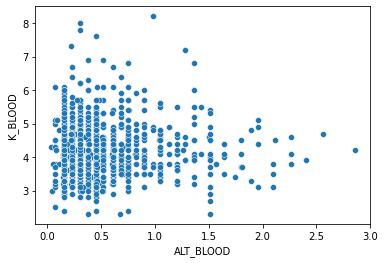

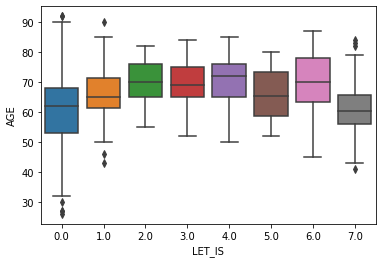

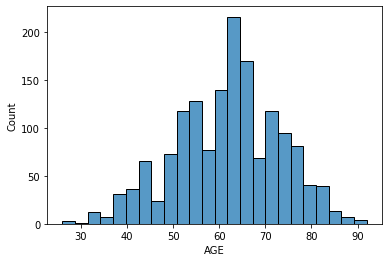

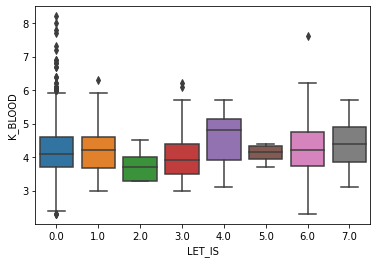

In [ ]:
X = df.to_numpy()[:,1:]

plt.figure()
sns.scatterplot(data=df,x='ALT_BLOOD',y='K_BLOOD')
plt.figure()
sns.boxplot(data=df,x='LET_IS',y='AGE')
plt.figure()
sns.histplot(df['AGE'])
plt.figure()
sns.boxplot(data=df,x='LET_IS',y='K_BLOOD')

In [ ]:
df.describe()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
count,1574.000000,1567.000000,1574.000000,1573.000000,1489.000000,1517.000000,1537.000000,1571.000000,1571.000000,1357.000000,1534.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1569.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1567.000000,1568.000000,1568.000000,1571.000000,1571.000000,1571.000000,1571.000000,1571.000000,1328.000000,1327.000000,1564.000000,1562.000000,1563.000000,1564.000000,1564.000000,...,1564.000000,1564.000000,1244.000000,1242.000000,1239.000000,1239.000000,1316.000000,1315.000000,1459.000000,1392.000000,1465.000000,1563.000000,1481.00000,1461.000000,1565.000000,1570.000000,1481.000000,1458.000000,1565.000000,1479.000000,1458.000000,1565.000000,1564.000000,1562.000000,1558.000000,1558.000000,1559.000000,1559.000000,1573.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1574.000000,1550.000000,1574.000000,1573.000000,1572.000000
mean,834.541931,61.641353,0.627700,0.546090,2.288113,1.197759,1.157450,1.386378,0.031190,3.313928,0.194263,0.024857,0.001912,0.010198,0.019758,0.017208,0.000637,0.002549,0.001273,0.001910,0.006365,0.000637,0.003183,0.001273,0.001910,0.137843,0.023597,0.008291,0.077021,0.068746,0.022279,0.005092,0.013367,134.736446,82.942728,0.063939,0.023688,0.067179,0.004476,0.003836,...,0.003836,0.001279,0.401125,4.196860,0.024213,136.505246,0.485517,0.265970,8.774839,13.428879,4.656655,0.327575,0.13977,0.074606,0.118211,0.486624,0.095206,0.055556,0.334824,0.115619,0.088477,0.290735,0.128517,0.674136,0.716945,0.752246,0.018602,0.202053,0.098538,0.010801,0.025413,0.041931,0.033037,0.090851,0.033672,0.045743,0.234839,0.088945,0.082009,0.480916
std,493.762248,11.356198,0.483571,0.890974,2.435926,1.056664,0.802785,1.089167,0.173887,3.098704,0.661153,0.155738,0.043699,0.100499,0.139211,0.130089,0.025246,0.050443,0.035669,0.043671,0.079554,0.025230,0.056343,0.035669,0.043671,0.344845,0.151838,0.090705,0.266710,0.253102,0.147636,0.071201,0.114878,30.201007,17.550480,0.244722,0.152123,0.250411,0.066772,0.061839,...,0.061839,0.035748,0.490323,0.760983,0.153772,6.541388,0.391009,0.204804,3.416889,11.446904,2.862550,0.721129,0.42080,0.306178,0.402304,0.791212,0.357899,0.265236,0.634954,0.405668,0.364509,0.454247,0.334771,0.468847,0.450628,0.431847,0.135157,0.401660,0.298135,0.103396,0.157426,0.200496,0.178790,0.287489,0.180441,0.208994,0.424035,0.284755,0.274466,1.386125
min,1.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.300000,0.000000,117.000000,0.030000,0.040000,2.000000,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,401.250000,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

Check how many binary, continuous and ordinal variables.

In [ ]:
!git clone https://github.com/auranic/ClinTrajan

Cloning into 'ClinTrajan'...
remote: Enumerating objects: 344, done.
remote: Counting objects: 100% (344/344), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 344 (delta 156), reused 235 (delta 85), pack-reused 0
Receiving objects: 100% (344/344), 46.42 MiB | 31.46 MiB/s, done.
Resolving deltas: 100% (156/156), done.


In [ ]:
import sys
sys.path.append('./ClinTrajan/code')
from clintraj_qi import *
from clintraj_util import *
from clintraj_optiscale import *

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
variable_types, binary, continuous, ordinal = detect_variable_type(df,10,verbose=False)

In [ ]:
print(f'Binary variables ({len(binary)}): {binary}')
print(f'Continuous variables ({(len(continuous))}): {continuous}')
print(f'Ordinal variables ({len(ordinal)}): {ordinal}')

Binary variables (84): ['SEX', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01', 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'GIPER_NA', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_

## <a name="sec2">2. Imputation</a>

__Imputation__ is the process of replacing missing data with substitued values ([wiki](https://en.wikipedia.org/wiki/Imputation_(statistics)#:~:text=In%20statistics%2C%20imputation%20is%20the,missing%20data%20with%20substituted%20values.&text=That%20is%20to%20say%2C%20when,the%20representativeness%20of%20the%20results.)). 

Let's check missing values and then try several strategies for imputing them.

In [ ]:
# Detect missing values for each feature
df.isna().sum()

ID            0
AGE           7
SEX           0
INF_ANAM      1
STENOK_AN    85
             ..
DRESSLER      0
ZSN          24
REC_IM        0
P_IM_STEN     1
LET_IS        2
Length: 117, dtype: int64

In [ ]:
# Total of missing values in the whole dataset
total_missing_values = np.sum(df.isna().sum())
missing_values_percentage = total_missing_values * 100 / (df.shape[0] * df.shape[1])
print(f'Missing values {total_missing_values} ({missing_values_percentage})')

# Total of complete rows
num_complete_rows = df.dropna().shape[0]
num_complete_rows_percentage = num_complete_rows * 100 / df.shape[0]
print(f'Number of complete rows {num_complete_rows} ({num_complete_rows_percentage})')

Missing values 4782 (2.596683282833219)
Number of complete rows 532 (33.7992376111817)


As one can see, only 33% of rows have complete values for all columns.

### <a name="sec2-1">2.1 Delete rows with missing values</a>

The first strategy is to simply delete rows with missing values.

In [ ]:
df_dropna = df.dropna()

In [ ]:
print(df.shape)
print(df_dropna.shape)

(1574, 117)
(532, 117)


The number of rows is reduced by approximately  66%. There is a lot of rows with NaN values so this method isn't satisfying.
Indeed, as seen before, there's only 532 compete rows.


### <a name="sec2-2">2.2 Replace NaN values with mean</a>

The second strategy is to replace NaN values with the mean value of the corresponding feature. We can use `SimpleImputer` from Scikit-Learn.

In [ ]:
from sklearn.impute import SimpleImputer

In [ ]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
array_imp_mean = imp_mean.fit_transform(df.to_numpy())
df_mean = pd.DataFrame(array_imp_mean, columns=df.columns)

In [ ]:
df_mean.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1569,1695.0,77.0,0.0,0.0,0.000000,0.000000,0.00000,2.0,0.0,7.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,3.90000,0.000000,136.000000,0.230000,0.18000,5.500000,20.000000,3.0,0.0,0.00000,0.000000,1.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1570,1696.0,77.0,0.0,0.0,4.000000,2.000000,1.00000,2.0,0.0,7.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,3.70000,0.000000,130.000000,1.050000,0.52000,12.800000,6.000000,2.0,0.0,0.13977,0.074606,0.0,0.0,0.095206,0.055556,0.0,0.115619,0.088477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1571,1697.0,70.0,0.0,0.0,6.000000,2.000000,1.00000,2.0,0.0,7.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.401125,4.19686,0.024213,136.505246,0.485517,0.26597,8.774839,13.428879,2.0,0.0,0.13977,0.074606,0.0,0.0,0.095206,0.055556,0.0,0.115619,0.088477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1572,1699.0,79.0,0.0,2.0,2.000000,2.000000,1.00000,2.0,0.0,7.000000,0.194263,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.000000,3.10000,0.000000,136.000000,0.450000,0.45000,7.500000,4.000000,2.0,1.0,0.13977,0.074606,1.0,2.0,0.095206,0.055556,1.0,0.115619,0.088477,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1573,1700.0,63.0,1.0,2.0,2.288113,1.197759,1.15745,2.0,0.0,3.313928,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.401125,4.19686,0.024213,136.505246,0.485517,0.26597,8.774839,13.428879,1.0,0.0,0.13977,0.074606,1.0,0.0,0.095206,0.055556,0.0,0.115619,0.088477,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1569,1695,77.0,0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,136.0,0.23,0.18,5.5,20.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0.0,0,0.0,3.0
1570,1696,77.0,0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.7,0.0,130.0,1.05,0.52,12.8,6.0,2.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0.0,0,0.0,3.0
1571,1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,1.0
1572,1699,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.1,0.0,136.0,0.45,0.45,7.5,4.0,2.0,1.0,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0.0,0,0.0,1.0
1573,1700,63.0,1,2.0,NaN,NaN,NaN,2.0,0.0,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,1.0


But for some features, the values must be an int (category) and not a float. The mean doesn't always give an int, so it won't make anything good.


### <a name="sec2-3">2.3 Replace NaN values with median</a>

Instead, the median may be a better approach. But the problem is that we replace the missing value by the same one in every sample.

In [ ]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
array_imp_median = imp_median.fit_transform(df.to_numpy())
df_median = pd.DataFrame(array_imp_median, columns=df.columns)

In [ ]:
df_median.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1569,1695.0,77.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,136.0,0.23,0.18,5.5,20.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1570,1696.0,77.0,0.0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.7,0.0,130.0,1.05,0.52,12.8,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1571,1697.0,70.0,0.0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.1,0.0,136.0,0.38,0.22,8.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1572,1699.0,79.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.1,0.0,136.0,0.45,0.45,7.5,4.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1573,1700.0,63.0,1.0,2.0,1.0,2.0,1.0,2.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.1,0.0,136.0,0.38,0.22,8.0,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1569,1695,77.0,0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,136.0,0.23,0.18,5.5,20.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0.0,0,0.0,3.0
1570,1696,77.0,0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.7,0.0,130.0,1.05,0.52,12.8,6.0,2.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0.0,0,0.0,3.0
1571,1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,1.0
1572,1699,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.1,0.0,136.0,0.45,0.45,7.5,4.0,2.0,1.0,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0.0,0,0.0,1.0
1573,1700,63.0,1,2.0,NaN,NaN,NaN,2.0,0.0,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,1.0


### <a name="sec2-4"> 2.4 Replace NaN values with most frequent value </a>

We can replace missing values using the most frequent value along each column. The problem is the same as before.

In [ ]:
imp_freq = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
array_imp_freq = imp_freq.fit_transform(df.to_numpy())
df_freq = pd.DataFrame(array_imp_freq, columns=df.columns)

In [ ]:
df_freq.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1569,1695.0,77.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,136.0,0.23,0.18,5.5,20.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1570,1696.0,77.0,0.0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.7,0.0,130.0,1.05,0.52,12.8,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1571,1697.0,70.0,0.0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,136.0,0.15,0.15,6.8,5.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1572,1699.0,79.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.1,0.0,136.0,0.45,0.45,7.5,4.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1573,1700.0,63.0,1.0,2.0,0.0,2.0,2.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,0.0,136.0,0.15,0.15,6.8,5.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1569,1695,77.0,0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,136.0,0.23,0.18,5.5,20.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0,0,0,0,0,1,0,0.0,0,0.0,3.0
1570,1696,77.0,0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.7,0.0,130.0,1.05,0.52,12.8,6.0,2.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0,1,0,0.0,0,0.0,3.0
1571,1697,70.0,0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.0,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,1.0
1572,1699,79.0,0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.1,0.0,136.0,0.45,0.45,7.5,4.0,2.0,1.0,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0.0,0,0.0,1.0
1573,1700,63.0,1,2.0,NaN,NaN,NaN,2.0,0.0,NaN,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,NaN,NaN,1.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0.0,0,0.0,1.0


### <a name="sec2-5"> 2.5 Multivariate imputer</a>

 We could also try the Multivariate feature imputation.

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
imp = IterativeImputer(max_iter=10, random_state=0)

In [ ]:
array_it = imp.fit_transform(df.to_numpy())

In [ ]:
df_it = pd.DataFrame(array_it)

In [ ]:
df_it.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116
1569,1695.0,77.0,0.0,0.0,0.000000,0.000000,0.000000,2.0,0.0,7.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,3.900000,0.000000,136.000000,0.230000,0.180000,5.500000,20.000000,3.0,0.0,0.000000,0.000000,1.0,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1570,1696.0,77.0,0.0,0.0,4.000000,2.000000,1.000000,2.0,0.0,7.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.000000,3.700000,0.000000,130.000000,1.050000,0.520000,12.800000,6.000000,2.0,0.0,-0.040377,0.100291,0.0,0.0,-0.078721,0.046755,0.0,0.145685,0.235145,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1571,1697.0,70.0,0.0,0.0,6.000000,2.000000,1.000000,2.0,0.0,7.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.381939,4.184447,0.012140,135.701462,0.367392,0.220206,12.013510,14.600787,2.0,0.0,0.124542,0.032373,0.0,0.0,0.113330,0.002713,0.0,0.006511,0.006209,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1572,1699.0,79.0,0.0,2.0,2.000000,2.000000,1.000000,2.0,0.0,7.000000,0.675429,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.000000,3.100000,0.000000,136.000000,0.450000,0.450000,7.500000,4.000000,2.0,1.0,0.349194,0.008331,1.0,2.0,0.291280,0.076907,1.0,0.172986,0.127245,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1573,1700.0,63.0,1.0,2.0,3.978911,2.128338,1.547626,2.0,0.0,4.337185,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.405195,4.321962,0.025857,135.282563,0.710773,0.297495,12.898587,13.077972,1.0,0.0,0.187829,0.053355,1.0,0.0,0.319930,0.080105,0.0,0.079187,0.145624,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Again, the values are not int.

### <a name="sec2-6"> 2.6 KNN Imputation </a>

Finally, we can try KNN algorithm.
We only choose the closest neighbor, since choosing more neighbors leads to a mean computation, so a float, which is the same problem as before for categorical data.

Here the choosen value is the one of the closest neighbor, this way, each value is selected according to the sample.

Another solution would be to take the majoritary class among the closests k neighbors.

In [ ]:
from sklearn.impute import KNNImputer

In [ ]:
# Choose the closest neighbor
imp_knn = KNNImputer(n_neighbors=1)
array_imp_knn = imp_knn.fit_transform(df.to_numpy())
df_knn = pd.DataFrame(array_imp_knn, columns=df.columns)

In [ ]:
df_knn.tail()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
1569,1695.0,77.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0,90.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,136.0,0.23,0.18,5.5,20.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1570,1696.0,77.0,0.0,0.0,4.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.7,0.0,130.0,1.05,0.52,12.8,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0
1571,1697.0,70.0,0.0,0.0,6.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,3.9,0.0,140.0,0.23,0.11,13.9,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1572,1699.0,79.0,0.0,2.0,2.0,2.0,1.0,2.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,110.0,70.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,3.1,0.0,136.0,0.45,0.45,7.5,4.0,2.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1573,1700.0,63.0,1.0,2.0,6.0,2.0,1.0,2.0,0.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.8,0.0,128.0,1.89,1.08,12.1,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### <a name="sec2-7"> 2.7 SVD Imputation </a>

From https://github.com/auranic/ClinTrajan/blob/master/tutorial/tutorial.md

The idea is to compute SVD on the complete part of the data matrix and then project the data points with missing variables onto the principal components. The imputed value will be the value of the variable in the projection point.

In [ ]:
dfq, replacement_info = quantify_dataframe_univariate(df,variable_types)
with open('temp.txt','w') as fid:
    fid.write(replacement_info)

Matrix shape: (532, 116)
Effective linear dimension 24
Full matrix shape (1574, 116)


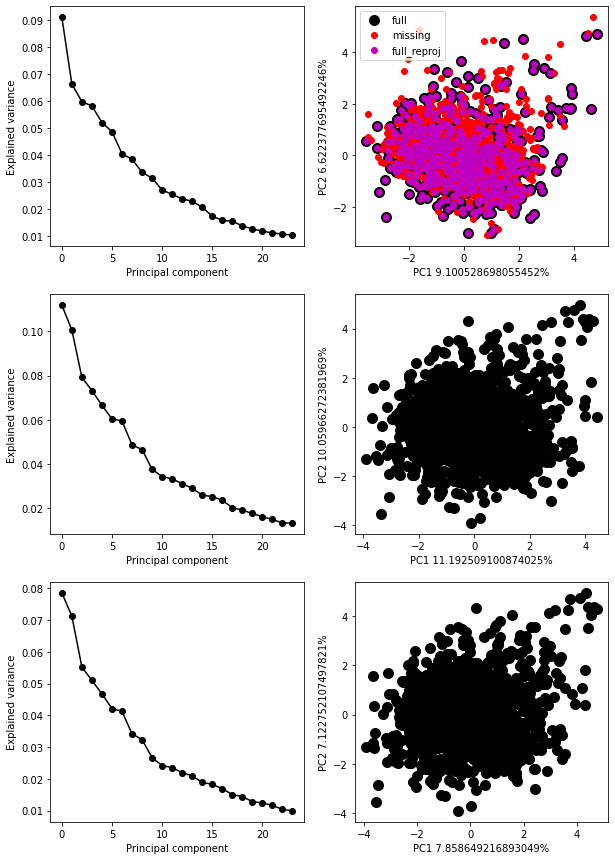

In [ ]:
dfq_imputed = SVDcomplete_imputation_method(dfq, variable_types, verbose=True, num_components=-1)
dequant_info = invert_quant_info(load_quantification_info('temp.txt'))
df_imputed = dequantify_table(dfq_imputed,dequant_info)
#display(df_imputed)

## <a name="sec3">3. Check if the dataset needs to be normalized in a particular way</a>

Challenge: the clinical dataset contains a mix of continuous and categorical variables. 
- A continuous variable takes its values in $\mathbb{R}$ (e.g. age, salary, height etc.)
- A categorical variable takes its values in a list of $m$ modalities, with $m \geq 2$ (e.g. sex, country, eye color etc.)

PCA is known to be effective for continuous data but not for categorical data. In this [article](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210), the author presents the __Factorial Analysis of Mixed Data__ (FAMD), which generalizes the PCA algorithm to datasets containing continuous and categorical variables, as the clinical dataset. 
The FAMD algorithm gives the exact same weight to all the variables, continuous or categorical, when searching for the k principal components. To do so, it will look iteratively for the components $C$ that maximize:
- the __square correlation coefficient__ $r^2(v, C)$ when $v$ is continuous. It takes values in [0,1], and will get increasingly high as $v$ and $C$ are more correlated.
- the __square correlation ratio__ $\eta^2(v, C)$ when $v$ is categorical. Also takes values in [0,1]. The more $\eta^2(v, C)$ is close to 1, the more knowledge of the modality taken by $v$ gives a powerful indication on the value taken by $C$.

$r^2(v, C)$ and $\eta^2(v, C)$ both indicate the correlation to $C$ and get higher as the variable $v$ (continuous or categorical) is significantly correlated to $C$. As a result, we can compare them while giving as much importance to the continuous or categorical variable.


The FAMD algorithm:
1. Standard scale the continuous variables
2. For the categorical variables:
    * Get the one-hot encoded columns
    * Divide each column by the square root of its probability (number of ones in the column divided by the number of samples)
    * Center the columns
3. Apply a PCA algorithm over the scaled data





### 3.1 Standard scale the numerical variables


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler() 
df_imputed_continuous_scaled = df_imputed.copy()
df_imputed_continuous_scaled[continuous] = scaler.fit_transform(df_imputed[continuous])

In [ ]:
df_imputed.head()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,77.0,1,2,1,1,2,3,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,100.0,0,0,0,0,0,...,0,0,0,4.7,0,138.0,0.506294,0.252351,8.000000,16.000000,4,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,55.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,120.0,90.0,0,0,0,0,0,...,0,0,1,3.5,0,132.0,0.380000,0.180000,7.800000,3.000000,2,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,52.0,1,0,0,0,2,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,180.0,100.0,0,0,0,0,0,...,0,0,0,4.0,0,132.0,0.300000,0.110000,10.800000,13.107450,3,3,0,0,0,1,0,0,3,2,2,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,68.0,0,0,0,0,2,2,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,120.0,70.0,0,0,0,0,0,...,0,0,1,3.9,0,146.0,0.750000,0.370000,8.355025,14.216277,2,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5,60.0,1,0,0,0,2,3,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,160.0,90.0,0,0,0,0,0,...,0,0,1,3.5,0,132.0,0.450000,0.220000,8.300000,13.511466,9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_imputed_continuous_scaled.head()

,ID,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,np_04,np_05,np_07,np_08,np_09,np_10,endocr_01,endocr_02,endocr_03,zab_leg_01,zab_leg_02,zab_leg_03,zab_leg_04,zab_leg_06,S_AD_ORIT,D_AD_ORIT,O_L_POST,K_SH_POST,MP_TP_POST,SVT_POST,GT_POST,...,fibr_ter_07,fibr_ter_08,GIPO_K,K_BLOOD,GIPER_NA,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,TIME_B_S,R_AB_1_n,R_AB_2_n,R_AB_3_n,NITR_S,NA_R_1_n,NA_R_2_n,NA_R_3_n,NOT_NA_1_n,NOT_NA_2_n,NOT_NA_3_n,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,FIBR_PREDS,PREDS_TAH,JELUD_TAH,FIBR_JELUD,A_V_BLOK,OTEK_LANC,RAZRIV,DRESSLER,ZSN,REC_IM,P_IM_STEN,LET_IS
0,1,1.356125,1,2,1,1,2,3,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.61721,1.033811,0,0,0,0,0,...,0,0,0,0.763446,0,0.274055,0.056531,-0.073498,-0.229490,0.238454,4,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,-0.586044,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.54375,0.414562,0,0,0,0,0,...,0,0,1,-1.010404,0,-0.759085,-0.296745,-0.460033,-0.290283,-0.969406,2,0,0,0,0,0,0,0,1,0,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,3,-0.850885,1,0,0,0,2,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.61721,1.033811,0,0,0,0,0,...,0,0,0,-0.271300,0,-0.759085,-0.520525,-0.834006,0.621619,-0.030300,3,3,0,0,0,1,0,0,3,2,2,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0.561602,0,0,0,0,2,2,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,-0.54375,-0.823938,0,0,0,0,0,...,0,0,1,-0.419121,0,1.651575,0.738239,0.555038,-0.121574,0.072724,2,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,5,-0.144642,1,0,0,0,2,3,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.89689,0.414562,0,0,0,0,0,...,0,0,1,-1.010404,0,-0.759085,-0.100937,-0.246334,-0.138299,0.007238,9,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0


### 3.2 Scale categorical variables

In [ ]:
categorical_variables = binary + ordinal
print(len(categorical_variables), categorical_variables)

107 ['SEX', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01', 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'GIPER_NA', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n', 'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n', 'FIBR_PREDS', '

In [ ]:
# Drop column ID
df_imputed_scaled = df_imputed_continuous_scaled.copy()
df_imputed_scaled.drop(['ID'], axis=1, inplace=True)

In [ ]:
# Get the one-hot encoded columns

for col in categorical_variables:
    df_imputed_scaled = pd.concat([df_imputed_scaled, pd.get_dummies(df_imputed_scaled[col], prefix=col)], axis=1)

df_imputed_scaled.drop(categorical_variables, axis=1, inplace=True)
df_imputed_scaled.head()

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,SEX_0,SEX_1,SIM_GIPERT_0,SIM_GIPERT_1,nr_11_0,nr_11_1,nr_01_0,nr_01_1,nr_02_0,nr_02_1,nr_03_0,nr_03_1,nr_04_0,nr_04_1,nr_07_0,nr_07_1,nr_08_0,nr_08_1,np_01_0,np_01_1,np_04_0,np_04_1,np_05_0,np_05_1,np_07_0,np_07_1,np_08_0,np_08_1,np_09_0,np_09_1,np_10_0,...,R_AB_3_n_1,R_AB_3_n_2,R_AB_3_n_4,NITR_S_0,NITR_S_1,NITR_S_10,NA_R_1_n_0,NA_R_1_n_1,NA_R_1_n_2,NA_R_1_n_3,NA_R_1_n_4,NA_R_1_n_5,NA_R_1_n_6,NA_R_2_n_0,NA_R_2_n_1,NA_R_2_n_2,NA_R_2_n_3,NA_R_3_n_0,NA_R_3_n_1,NA_R_3_n_2,NOT_NA_1_n_0,NOT_NA_1_n_1,NOT_NA_1_n_2,NOT_NA_1_n_3,NOT_NA_1_n_4,NOT_NA_2_n_0,NOT_NA_2_n_1,NOT_NA_2_n_2,NOT_NA_2_n_3,NOT_NA_3_n_0,NOT_NA_3_n_1,NOT_NA_3_n_2,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1.356125,1.61721,1.033811,0.763446,0.274055,0.056531,-0.073498,-0.229490,0.238454,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
1,-0.586044,-0.54375,0.414562,-1.010404,-0.759085,-0.296745,-0.460033,-0.290283,-0.969406,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,-0.850885,1.61721,1.033811,-0.271300,-0.759085,-0.520525,-0.834006,0.621619,-0.030300,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0
3,0.561602,-0.54375,-0.823938,-0.419121,1.651575,0.738239,0.555038,-0.121574,0.072724,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,-0.144642,0.89689,0.414562,-1.010404,-0.759085,-0.100937,-0.246334,-0.138299,0.007238,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0


In [ ]:
new_categorical_variables = [col for col in df_imputed_scaled.columns if col not in continuous]
print(len(new_categorical_variables), new_categorical_variables)

290 ['SEX_0', 'SEX_1', 'SIM_GIPERT_0', 'SIM_GIPERT_1', 'nr_11_0', 'nr_11_1', 'nr_01_0', 'nr_01_1', 'nr_02_0', 'nr_02_1', 'nr_03_0', 'nr_03_1', 'nr_04_0', 'nr_04_1', 'nr_07_0', 'nr_07_1', 'nr_08_0', 'nr_08_1', 'np_01_0', 'np_01_1', 'np_04_0', 'np_04_1', 'np_05_0', 'np_05_1', 'np_07_0', 'np_07_1', 'np_08_0', 'np_08_1', 'np_09_0', 'np_09_1', 'np_10_0', 'np_10_1', 'endocr_01_0', 'endocr_01_1', 'endocr_02_0', 'endocr_02_1', 'endocr_03_0', 'endocr_03_1', 'zab_leg_01_0', 'zab_leg_01_1', 'zab_leg_02_0', 'zab_leg_02_1', 'zab_leg_03_0', 'zab_leg_03_1', 'zab_leg_04_0', 'zab_leg_04_1', 'zab_leg_06_0', 'zab_leg_06_1', 'O_L_POST_0', 'O_L_POST_1', 'K_SH_POST_0', 'K_SH_POST_1', 'MP_TP_POST_0', 'MP_TP_POST_1', 'SVT_POST_0', 'SVT_POST_1', 'GT_POST_0', 'GT_POST_1', 'FIB_G_POST_0', 'FIB_G_POST_1', 'IM_PG_P_0', 'IM_PG_P_1', 'ritm_ecg_p_01_0', 'ritm_ecg_p_01_1', 'ritm_ecg_p_02_0', 'ritm_ecg_p_02_1', 'ritm_ecg_p_04_0', 'ritm_ecg_p_04_1', 'ritm_ecg_p_06_0', 'ritm_ecg_p_06_1', 'ritm_ecg_p_07_0', 'ritm_ecg_p_07

In [ ]:
# Divide each column by the square root of its probability (number of ones in the column divided by the number of samples)

n_samples = df_imputed_scaled.shape[0]

for col in new_categorical_variables:
    proba = df_imputed_scaled[col].sum() / n_samples
    df_imputed_scaled[col] = df_imputed_scaled[col].apply(lambda x: x / np.sqrt(proba))

df_imputed_scaled.head()

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,SEX_0,SEX_1,SIM_GIPERT_0,SIM_GIPERT_1,nr_11_0,nr_11_1,nr_01_0,nr_01_1,nr_02_0,nr_02_1,nr_03_0,nr_03_1,nr_04_0,nr_04_1,nr_07_0,nr_07_1,nr_08_0,nr_08_1,np_01_0,np_01_1,np_04_0,np_04_1,np_05_0,np_05_1,np_07_0,np_07_1,np_08_0,np_08_1,np_09_0,np_09_1,np_10_0,...,R_AB_3_n_1,R_AB_3_n_2,R_AB_3_n_4,NITR_S_0,NITR_S_1,NITR_S_10,NA_R_1_n_0,NA_R_1_n_1,NA_R_1_n_2,NA_R_1_n_3,NA_R_1_n_4,NA_R_1_n_5,NA_R_1_n_6,NA_R_2_n_0,NA_R_2_n_1,NA_R_2_n_2,NA_R_2_n_3,NA_R_3_n_0,NA_R_3_n_1,NA_R_3_n_2,NOT_NA_1_n_0,NOT_NA_1_n_1,NOT_NA_1_n_2,NOT_NA_1_n_3,NOT_NA_1_n_4,NOT_NA_2_n_0,NOT_NA_2_n_1,NOT_NA_2_n_2,NOT_NA_2_n_3,NOT_NA_3_n_0,NOT_NA_3_n_1,NOT_NA_3_n_2,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1.356125,1.61721,1.033811,0.763446,0.274055,0.056531,-0.073498,-0.229490,0.238454,0.000000,1.262188,1.015939,0.0,1.012624,0.0,1.000954,0.0,1.005122,0.0,1.009995,0.0,1.008689,0.0,1.000318,0.0,1.001273,0.0,1.000636,0.0,1.000954,0.0,1.003192,0.0,1.000318,0.0,1.001592,0.0,1.000636,0.0,1.000954,...,4.408185,0.0,0.0,1.061082,0.0,0.0,1.236186,0.000000,0.0,0.0,0.0,0.0,0.0,1.037242,0.0,0.0,0.0,1.022327,0.0,0.0,1.16839,0.000000,0.0,0.000000,0.0,1.043322,0.0,0.000000,0.0,1.030224,0.0,0.000000,1.090743,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.586044,-0.54375,0.414562,-1.010404,-0.759085,-0.296745,-0.460033,-0.290283,-0.969406,0.000000,1.262188,1.015939,0.0,1.012624,0.0,1.000954,0.0,1.005122,0.0,1.009995,0.0,1.008689,0.0,1.000318,0.0,1.001273,0.0,1.000636,0.0,1.000954,0.0,1.003192,0.0,1.000318,0.0,1.001592,0.0,1.000636,0.0,1.000954,...,0.000000,0.0,0.0,1.061082,0.0,0.0,1.236186,0.000000,0.0,0.0,0.0,0.0,0.0,1.037242,0.0,0.0,0.0,1.022327,0.0,0.0,0.00000,2.123683,0.0,0.000000,0.0,1.043322,0.0,0.000000,0.0,1.030224,0.0,0.000000,1.090743,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.850885,1.61721,1.033811,-0.271300,-0.759085,-0.520525,-0.834006,0.621619,-0.030300,0.000000,1.262188,1.015939,0.0,1.012624,0.0,1.000954,0.0,1.005122,0.0,1.009995,0.0,1.008689,0.0,1.000318,0.0,1.001273,0.0,1.000636,0.0,1.000954,0.0,1.003192,0.0,1.000318,0.0,1.001592,0.0,1.000636,0.0,1.000954,...,0.000000,0.0,0.0,1.061082,0.0,0.0,0.000000,2.029881,0.0,0.0,0.0,0.0,0.0,1.037242,0.0,0.0,0.0,1.022327,0.0,0.0,0.00000,0.000000,0.0,9.622278,0.0,0.000000,0.0,6.522311,0.0,0.000000,0.0,6.435919,1.090743,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.561602,-0.54375,-0.823938,-0.419121,1.651575,0.738239,0.555038,-0.121574,0.072724,1.638904,0.000000,1.015939,0.0,1.012624,0.0,1.000954,0.0,1.005122,0.0,1.009995,0.0,1.008689,0.0,1.000318,0.0,1.001273,0.0,1.000636,0.0,1.000954,0.0,1.003192,0.0,1.000318,0.0,1.001592,0.0,1.000636,0.0,1.000954,...,4.408185,0.0,0.0,1.061082,0.0,0.0,1.236186,0.000000,0.0,0.0,0.0,0.0,0.0,1.037242,0.0,0.0,0.0,1.022327,0.0,0.0,1.16839,0.000000,0.0,0.000000,0.0,1.043322,0.0,0.000000,0.0,1.030224,0.0,0.000000,1.090743,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.144642,0.89689,0.414562,-1.010404,-0.759085,-0.100937,-0.246334,-0.138299,0.007238,0.000000,1.262188,1.015939,0.0,1.012624,0.0,1.000954,0.0,1.005122,0.0,1.009995,0.0,1.008689,0.0,1.000318,0.0,1.001273,0.0,1.000636,0.0,1.000954,0.0,1.003192,0.0,1.000318,0.0,1.001592,0.0,1.000636,0.0,1.000954,...,0.000000,0.0,0.0,1.061082,0.0,0.0,1.236186,0.000000,0.0,0.0,0.0,0.0,0.0,1.037242,0.0,0.0,0.0,1.022327,0.0,0.0,1.16839,0.000000,0.0,0.000000,0.0,1.043322,0.0,0.000000,0.0,1.030224,0.0,0.000000,1.090743,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Center the columns

for col in new_categorical_variables:
    mean = df_imputed_scaled[col].mean()
    df_imputed_scaled[col] = df_imputed_scaled[col].apply(lambda x: x - mean)

df_imputed_scaled.head()

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,SEX_0,SEX_1,SIM_GIPERT_0,SIM_GIPERT_1,nr_11_0,nr_11_1,nr_01_0,nr_01_1,nr_02_0,nr_02_1,nr_03_0,nr_03_1,nr_04_0,nr_04_1,nr_07_0,nr_07_1,nr_08_0,nr_08_1,np_01_0,np_01_1,np_04_0,np_04_1,np_05_0,np_05_1,np_07_0,np_07_1,np_08_0,np_08_1,np_09_0,np_09_1,np_10_0,...,R_AB_3_n_1,R_AB_3_n_2,R_AB_3_n_4,NITR_S_0,NITR_S_1,NITR_S_10,NA_R_1_n_0,NA_R_1_n_1,NA_R_1_n_2,NA_R_1_n_3,NA_R_1_n_4,NA_R_1_n_5,NA_R_1_n_6,NA_R_2_n_0,NA_R_2_n_1,NA_R_2_n_2,NA_R_2_n_3,NA_R_3_n_0,NA_R_3_n_1,NA_R_3_n_2,NOT_NA_1_n_0,NOT_NA_1_n_1,NOT_NA_1_n_2,NOT_NA_1_n_3,NOT_NA_1_n_4,NOT_NA_2_n_0,NOT_NA_2_n_1,NOT_NA_2_n_2,NOT_NA_2_n_3,NOT_NA_3_n_0,NOT_NA_3_n_1,NOT_NA_3_n_2,LET_IS_0,LET_IS_1,LET_IS_2,LET_IS_3,LET_IS_4,LET_IS_5,LET_IS_6,LET_IS_7
0,1.356125,1.61721,1.033811,0.763446,0.274055,0.056531,-0.073498,-0.229490,0.238454,-0.610164,0.469912,0.031627,-0.176439,0.02509,-0.157409,0.001908,-0.043657,0.010217,-0.100823,0.019892,-0.140339,0.017303,-0.130972,0.000636,-0.025206,0.002545,-0.050411,0.001271,-0.035646,0.001908,-0.043657,0.006374,-0.079707,0.000636,-0.025206,0.003182,-0.056362,0.001271,-0.035646,0.001908,...,4.181335,-0.087315,-0.025206,0.118647,-0.333439,-0.025206,0.427246,-0.492640,-0.272641,-0.149119,-0.071292,-0.025206,-0.025206,0.073147,-0.228247,-0.133376,-0.025206,0.044167,-0.18693,-0.09088,0.312511,-0.470880,-0.17463,-0.103925,-0.066688,0.084844,-0.23645,-0.153320,-0.043657,0.059562,-0.1835,-0.155378,0.173937,-0.250793,-0.103925,-0.1835,-0.115507,-0.087315,-0.120882,-0.128524
1,-0.586044,-0.54375,0.414562,-1.010404,-0.759085,-0.296745,-0.460033,-0.290283,-0.969406,-0.610164,0.469912,0.031627,-0.176439,0.02509,-0.157409,0.001908,-0.043657,0.010217,-0.100823,0.019892,-0.140339,0.017303,-0.130972,0.000636,-0.025206,0.002545,-0.050411,0.001271,-0.035646,0.001908,-0.043657,0.006374,-0.079707,0.000636,-0.025206,0.003182,-0.056362,0.001271,-0.035646,0.001908,...,-0.226851,-0.087315,-0.025206,0.118647,-0.333439,-0.025206,0.427246,-0.492640,-0.272641,-0.149119,-0.071292,-0.025206,-0.025206,0.073147,-0.228247,-0.133376,-0.025206,0.044167,-0.18693,-0.09088,-0.855879,1.652803,-0.17463,-0.103925,-0.066688,0.084844,-0.23645,-0.153320,-0.043657,0.059562,-0.1835,-0.155378,0.173937,-0.250793,-0.103925,-0.1835,-0.115507,-0.087315,-0.120882,-0.128524
2,-0.850885,1.61721,1.033811,-0.271300,-0.759085,-0.520525,-0.834006,0.621619,-0.030300,-0.610164,0.469912,0.031627,-0.176439,0.02509,-0.157409,0.001908,-0.043657,0.010217,-0.100823,0.019892,-0.140339,0.017303,-0.130972,0.000636,-0.025206,0.002545,-0.050411,0.001271,-0.035646,0.001908,-0.043657,0.006374,-0.079707,0.000636,-0.025206,0.003182,-0.056362,0.001271,-0.035646,0.001908,...,-0.226851,-0.087315,-0.025206,0.118647,-0.333439,-0.025206,-0.808940,1.537242,-0.272641,-0.149119,-0.071292,-0.025206,-0.025206,0.073147,-0.228247,-0.133376,-0.025206,0.044167,-0.18693,-0.09088,-0.855879,-0.470880,-0.17463,9.518353,-0.066688,-0.958477,-0.23645,6.368991,-0.043657,-0.970662,-0.1835,6.280541,0.173937,-0.250793,-0.103925,-0.1835,-0.115507,-0.087315,-0.120882,-0.128524
3,0.561602,-0.54375,-0.823938,-0.419121,1.651575,0.738239,0.555038,-0.121574,0.072724,1.028740,-0.792275,0.031627,-0.176439,0.02509,-0.157409,0.001908,-0.043657,0.010217,-0.100823,0.019892,-0.140339,0.017303,-0.130972,0.000636,-0.025206,0.002545,-0.050411,0.001271,-0.035646,0.001908,-0.043657,0.006374,-0.079707,0.000636,-0.025206,0.003182,-0.056362,0.001271,-0.035646,0.001908,...,4.181335,-0.087315,-0.025206,0.118647,-0.333439,-0.025206,0.427246,-0.492640,-0.272641,-0.149119,-0.071292,-0.025206,-0.025206,0.073147,-0.228247,-0.133376,-0.025206,0.044167,-0.18693,-0.09088,0.312511,-0.470880,-0.17463,-0.103925,-0.066688,0.084844,-0.23645,-0.153320,-0.043657,0.059562,-0.1835,-0.155378,0.173937,-0.250793,-0.103925,-0.1835,-0.115507,-0.087315,-0.120882,-0.128524
4,-0.144642,0.89689,0.414562,-1.010404,-0.759085,-0.100937,-0.246334,-0.138299,0.007238,-0.610164,0.469912,0.031627,-0.176439,0.02509,-0.157409,0.001908,-0

## <a name="sec4">4. Give an estimate of intrinsic dimensionality of the dataset </a>

The __intrinsic dimension__ for a data set can be thought of as the number of variables needed in a minimal representation of the data ([wiki](https://en.wikipedia.org/wiki/Intrinsic_dimension#:~:text=The%20intrinsic%20dimension%20for%20a,minimal%20representation%20of%20the%20data.&text=Such%20intrinsic%20dimension%20estimation%20methods,parts%20of%20the%20data%20set.))

- https://github.com/j-bac/scikit-dimension/tree/master/skdim
- https://scikit-dimension.readthedocs.io/en/latest/quick_start.html

In [ ]:
!pip install scikit-dimension
import skdim

     |████████████████████████████████| 63 kB 2.2 MB/s 


Kernel restart when executing the 2nd line: `danco = skdim.id.DANCo().fit(data)` with and without GPU.

	WARNING:root:kernel 703f7f46-41d2-41ee-955d-4aab809fad80 restarted

In [ ]:
# SVD imputed data
data = df_imputed.to_numpy()

# Estimate global intrinsic dimension
##danco = skdim.id.DANCo().fit(data_norm)

# Estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
lpca = skdim.id.lPCA().fit_pw(data,
                              n_neighbors = 100,
                              n_jobs = 1)

# Get estimated intrinsic dimension
##print(danco.dimension_, np.mean(lpca.dimension_pw_))
print(np.mean(lpca.dimension_pw_))

3.741423125794155


Unfortunately skdim is not working. Instead, we tried to display a [scree plot](https://en.wikipedia.org/wiki/Scree_plot) in order to select the component that carry the more information. A scree plot is a line plot of the eigenvalues of principal components. According to the scree test, the "elbow" of the graph where the eigenvalues seem to level off is found and components to the left of this point should be retained as significant.

In [ ]:
# Define PCA model to use
pca = PCA(n_components = len(df_imputed_scaled.columns))

# Fit PCA model to data
pca_fit = pca.fit(df_imputed_scaled)

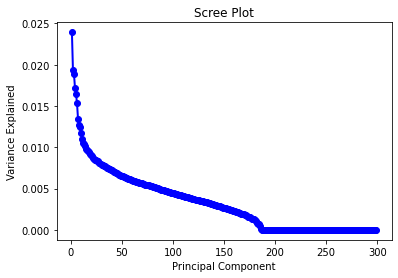

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, (pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
pca.explained_variance_ratio_

array([2.39326271e-02, 1.94095240e-02, 1.89013270e-02, 1.72127409e-02,
       1.64999657e-02, 1.53144192e-02, 1.33949943e-02, 1.26708992e-02,
       1.24321423e-02, 1.17009910e-02, 1.10251690e-02, 1.05462556e-02,
       1.03415745e-02, 1.01623918e-02, 9.84001088e-03, 9.69689494e-03,
       9.55888481e-03, 9.48380233e-03, 9.19161999e-03, 9.09698235e-03,
       8.90566594e-03, 8.74702992e-03, 8.54423018e-03, 8.45462930e-03,
       8.43597268e-03, 8.39903706e-03, 8.33329648e-03, 8.13055190e-03,
       8.01858183e-03, 7.90431240e-03, 7.85956851e-03, 7.79858239e-03,
       7.69357798e-03, 7.63983823e-03, 7.54682978e-03, 7.49194244e-03,
       7.42760960e-03, 7.32816972e-03, 7.27145574e-03, 7.23416909e-03,
       7.08848698e-03, 7.00604343e-03, 6.96507283e-03, 6.89258264e-03,
       6.85590383e-03, 6.74092461e-03, 6.68247571e-03, 6.63471404e-03,
       6.57154497e-03, 6.51399618e-03, 6.47370198e-03, 6.42884262e-03,
       6.35848268e-03, 6.30463162e-03, 6.28686260e-03, 6.20930531e-03,
      

Estimate intrinsic dimension around 15 based on the scree plot.

## <a name="sec5">5. Apply PCA and visualize the dataset in the space of two first principal components</a>

We arbitrarily define a target vector for the plot's colors. 

In [ ]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components=2)
pca_2 = pca2.fit_transform(df_imputed)

<Figure size 1080x360 with 0 Axes>

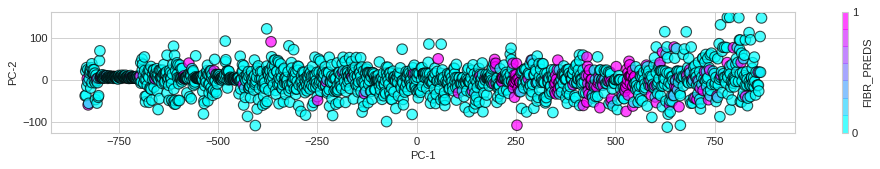

<Figure size 1080x360 with 0 Axes>

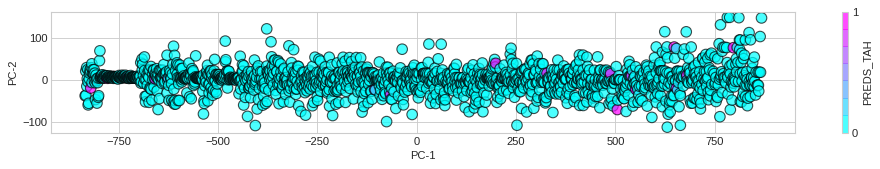

<Figure size 1080x360 with 0 Axes>

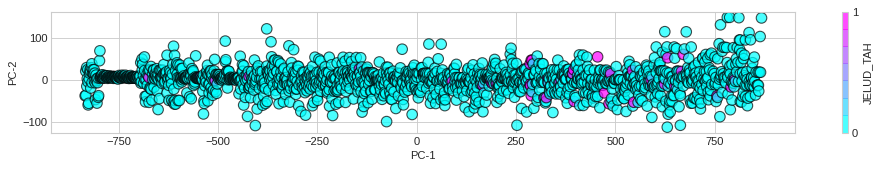

<Figure size 1080x360 with 0 Axes>

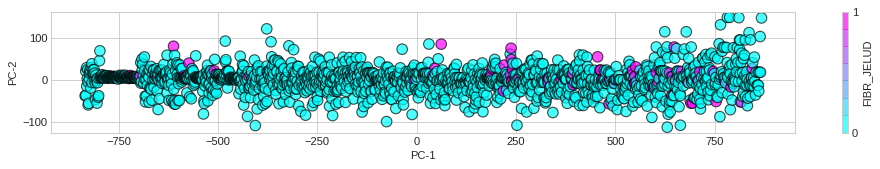

<Figure size 1080x360 with 0 Axes>

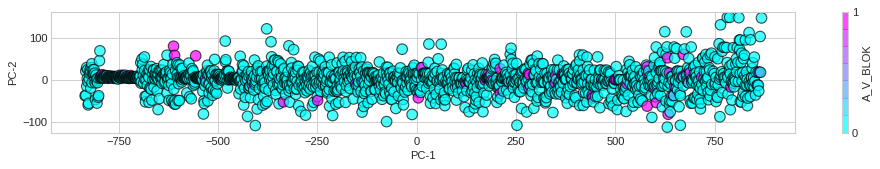

<Figure size 1080x360 with 0 Axes>

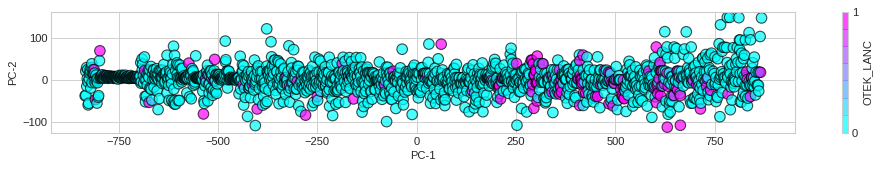

<Figure size 1080x360 with 0 Axes>

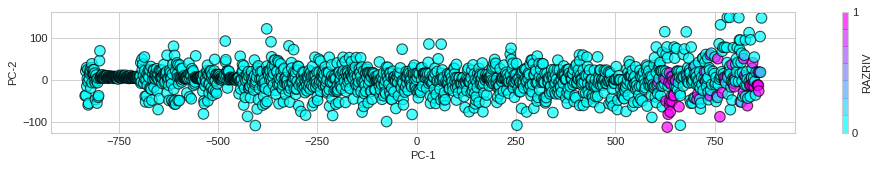

<Figure size 1080x360 with 0 Axes>

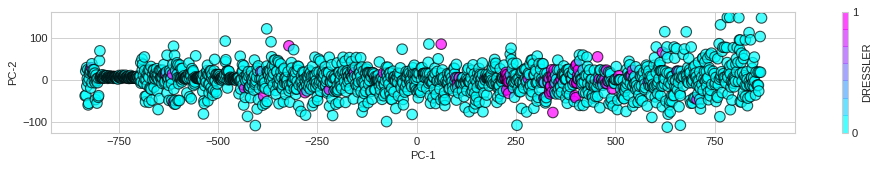

<Figure size 1080x360 with 0 Axes>

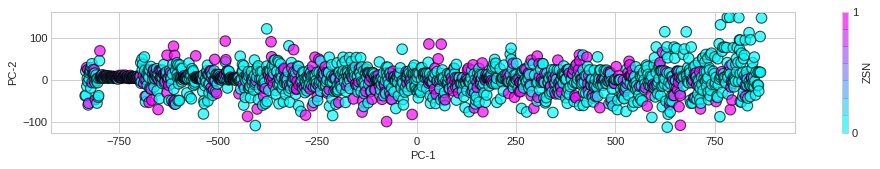

<Figure size 1080x360 with 0 Axes>

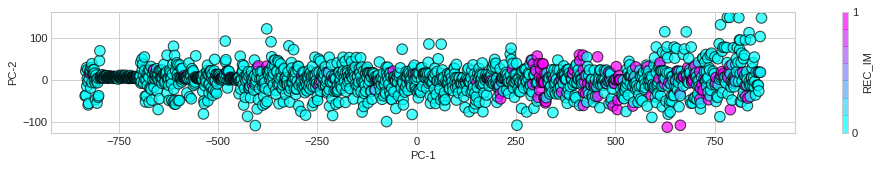

<Figure size 1080x360 with 0 Axes>

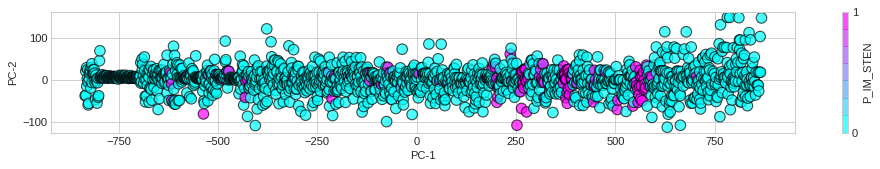

<Figure size 1080x360 with 0 Axes>

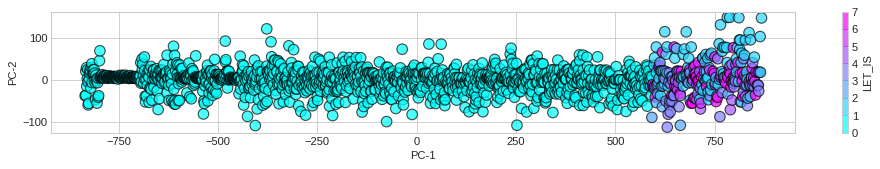

In [ ]:
# PCA 2
for i in np.arange(105, 117):
    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize = (15, 5))
    N = 7 #labels
    c_map = plt.cm.get_cmap('cool', N)
    bounds = np.linspace(0,N,N+1)
    plt.figure(figsize=(15, 2), dpi=80)
    scat = plt.scatter(pca_2[:, 0], pca_2[:, 1], cmap = c_map, edgecolor='k', s=90, alpha=0.7, c=df.iloc[:,i])
    cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
    cb.set_label(df.columns[i])
    plt.xlabel('PC-1')
    plt.ylabel('PC-2')
    plt.show()

## <a name="sec6">6. Investigate higher-order principal components, try to conclude if they contain useful information</a>

PCA using the intrinsic dimension = 15.

In this section, we perform PCA([2, 5, 15, 40, 100]) in order to predict a column and use the accuracy score as a measure of the information level.
More precisely, we predict complications at the end of the 3rd day:
- Column to predict: a complication among 
['FIBR_PREDS',
 'PREDS_TAH',
 'JELUD_TAH',
 'FIBR_JELUD',
 'A_V_BLOK',
 'OTEK_LANC',
 'RAZRIV',
 'DRESSLER',
 'ZSN',
 'REC_IM',
 'P_IM_STEN',
 'LET_IS']
- Input: all other columns except the column to predict

Expected results: best score with PCA(15) (and for higher-order dimension). For lower-order PC, the number of PC might not be sufficient to explain most of the variance in the dataset.




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
print(list(df_imputed.columns))
print(list(df_imputed_scaled.columns))

['ID', 'AGE', 'SEX', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'SIM_GIPERT', 'DLIT_AG', 'ZSN_A', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04', 'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09', 'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01', 'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'S_AD_ORIT', 'D_AD_ORIT', 'O_L_POST', 'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04', 'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01', 'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05', 'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10', 'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05', 'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09', 'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01', 'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06', 'fi

Columns indicating complications correspond to indexes 105 to 116 in `df_imputed`.

In [ ]:
complications_columns = list(df_imputed.columns[105:])
complications_columns

['FIBR_PREDS',
 'PREDS_TAH',
 'JELUD_TAH',
 'FIBR_JELUD',
 'A_V_BLOK',
 'OTEK_LANC',
 'RAZRIV',
 'DRESSLER',
 'ZSN',
 'REC_IM',
 'P_IM_STEN',
 'LET_IS']

Given the column name of a complication, remove the corresponding newly created columns in `df_imputed_scaled` by matching the complication with columns in `df_imputed_scaled`. 

For example, let's say we want to remove the corresponding columns of 'FIBR_PREDS' in `df_imputed_scaled`, which are 'FIBR_PREDS_0' and 'FIBR_PREDS_1'. First, we find the corresponding columns using matching pattern, then we retrieve the indexes of the columns and then remove those columns using indexed from the dataframe.

In [ ]:
def remove_columns(df, true_column_name):

    # Get all the columns that start with true_column_name
    columns_start_with_true_column_name = df.filter(regex=true_column_name).columns
    
    # Get the indexes of those columns in the dataframe
    indexes = []
    for col in columns_start_with_true_column_name:
        index = df.columns.get_loc(col)
        indexes.append(index)

    # Remove the columns given the indexes
    X = np.delete(np.array(df), obj=indexes, axis=1)

    return X

In [ ]:
def pca_quality(data_imputed, df_imputed_scaled, name_col_pred, idx_col_pred, k_pca, classifier):
    scores = []

    X = remove_columns(df_imputed_scaled, name_col_pred)
    Y = data_imputed[:, idx_col_pred] # Not one-hot encoded data

    pca = PCA(n_components=k_pca)
    X_pca = pca.fit_transform(X)
    X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y)

    if classifier == "knn":
        clf = KNeighborsClassifier(n_neighbors=7)
    if classifier == "dt":
        clf = DecisionTreeClassifier()

    # Train
    clf.fit(X_train, Y_train)

    # Compute accuracy
    score = clf.score(X_test, Y_test) 

    return score

In [ ]:
list_k_pca = [2, 5, 15, 40, 100]
list_idx_col_pred = np.arange(105, 117)
results = []
np_imputed = np.array(df_imputed)
np_imputed_scaled = np.array(df_imputed_scaled)

for k_pca in list_k_pca:    
    print(f"----- PCA({k_pca}) -----")
    scores = []
    for idx, name in zip(list_idx_col_pred, complications_columns):
        score = pca_quality(np_imputed, df_imputed_scaled, name, idx, k_pca, "knn")
        print(f"\tCol {idx}: \tscore={score:.6f}")
        scores.append(score)
    results.append(scores)

----- PCA(2) -----
	Col 105: 	score=0.878173
	Col 106: 	score=0.984772
	Col 107: 	score=0.979695
	Col 108: 	score=0.969543
	Col 109: 	score=0.959391
	Col 110: 	score=0.931472
	Col 111: 	score=0.969543
	Col 112: 	score=0.964467
	Col 113: 	score=0.715736
	Col 114: 	score=0.898477
	Col 115: 	score=0.916244
	Col 116: 	score=0.852792
----- PCA(5) -----
	Col 105: 	score=0.913706
	Col 106: 	score=0.992386
	Col 107: 	score=0.969543
	Col 108: 	score=0.961929
	Col 109: 	score=0.979695
	Col 110: 	score=0.918782
	Col 111: 	score=0.967005
	Col 112: 	score=0.951777
	Col 113: 	score=0.736041
	Col 114: 	score=0.918782
	Col 115: 	score=0.923858
	Col 116: 	score=0.837563
----- PCA(15) -----
	Col 105: 	score=0.903553
	Col 106: 	score=0.994924
	Col 107: 	score=0.987310
	Col 108: 	score=0.961929
	Col 109: 	score=0.969543
	Col 110: 	score=0.895939
	Col 111: 	score=0.956853
	Col 112: 	score=0.969543
	Col 113: 	score=0.746193
	Col 114: 	score=0.893401
	Col 115: 	score=0.893401
	Col 116: 	score=0.857868
----- 

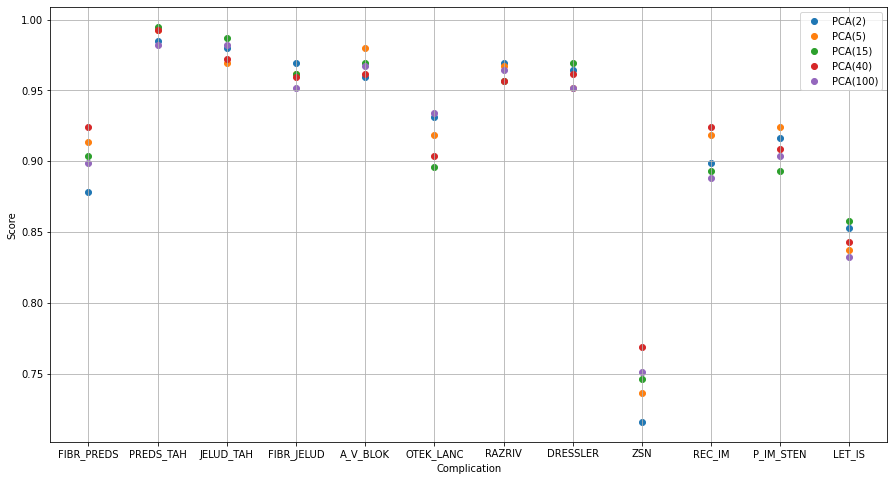

In [ ]:
plt.figure(figsize=(15, 8))
for i, k in enumerate(list_k_pca):    
    plt.scatter(x=list_idx_col_pred, y=results[i], label=f"PCA({k})")
plt.xlabel("Complication")
plt.xticks(list_idx_col_pred, complications_columns)
plt.ylabel("Score")
plt.legend()
plt.grid()
plt.show()

## <a name="sec8">8. Apply two or more different clustering methods using clustering quality criteria, compare the results as well as computational time </a>

We use the imputed data

### 8.1 DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
pca_2_imputed = pca2.fit_transform(df_imputed)
#pca_2_imputed_scaled = pca2.fit_transform(df_imputed_scaled)

In [ ]:
%time DBSCAN_clustering = DBSCAN(eps=26, min_samples=10).fit(df_imputed) 
DBSCAN_clustering.labels_

CPU times: user 59.1 ms, sys: 29.6 ms, total: 88.7 ms
Wall time: 89.4 ms


array([-1,  0, -1, ..., -1, -1, -1])

In [ ]:
np.unique(DBSCAN_clustering.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9])

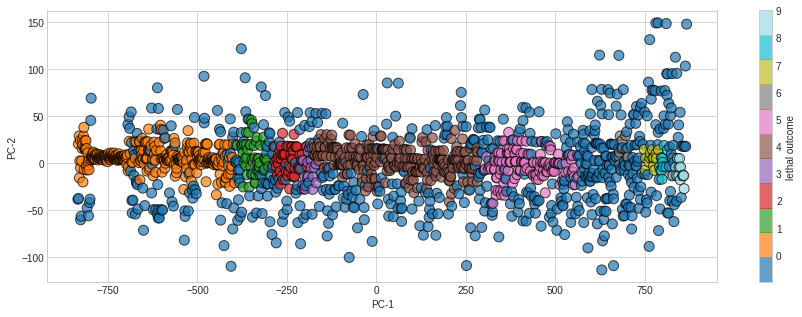

In [ ]:
# PCA 2
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (15, 5))
N = len(np.unique(DBSCAN_clustering.labels_)) #labels
c_map = plt.cm.get_cmap('tab20', N)
bounds = np.linspace(0,N,N+1)
scat = plt.scatter(pca_2_imputed[:, 0], pca_2_imputed[:, 1], cmap=c_map, edgecolor='k', s=100, c=DBSCAN_clustering.labels_, alpha=0.7)
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
#cb.set_ticklabels(names)
cb.set_label('lethal outcome')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

### 8.2 K-means

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
%time kmeans_clustering = KMeans(n_clusters=10).fit(df_imputed)
np.unique(kmeans_clustering.labels_)

CPU times: user 1.19 s, sys: 466 ms, total: 1.66 s
Wall time: 1.2 s


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

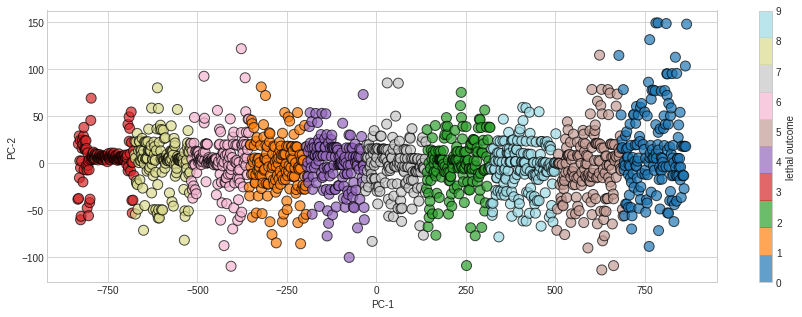

In [ ]:
# PCA 2
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (15, 5))
N = len(np.unique(kmeans_clustering.labels_)) #labels
c_map = plt.cm.get_cmap('tab20', N)
bounds = np.linspace(0,N,N+1)
scat = plt.scatter(pca_2_imputed[:, 0], pca_2_imputed[:, 1], cmap=c_map, edgecolor='k', s=100, c=kmeans_clustering.labels_, alpha=0.7)
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
#cb.set_ticklabels(names)
cb.set_label('lethal outcome')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

### 8.3 Spectral Clustering


In [ ]:
from sklearn.cluster import SpectralClustering

In [ ]:
%time spectral_clustering = SpectralClustering(n_clusters=10, assign_labels='discretize', random_state=0).fit(df_imputed)
np.unique(spectral_clustering.labels_)

CPU times: user 3min 47s, sys: 3min 4s, total: 6min 52s
Wall time: 4min 44s


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

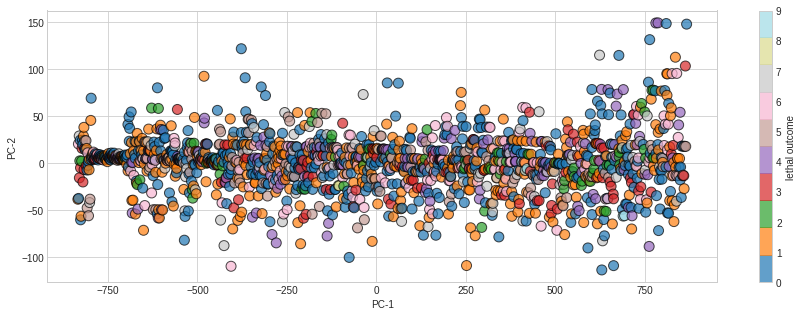

In [ ]:
#PCA 2
plt.style.use('seaborn-whitegrid')
plt.figure(figsize = (15, 5))
N = len(np.unique(spectral_clustering.labels_)) #labels
c_map = plt.cm.get_cmap('tab20', N)
bounds = np.linspace(0,N,N+1)
scat = plt.scatter(pca_2_imputed[:, 0], pca_2_imputed[:, 1], cmap=c_map, edgecolor='k', s=100, c=spectral_clustering.labels_, alpha=0.7)
cb = plt.colorbar(scat, spacing='proportional',ticks=bounds)
#cb.set_ticklabels(names)
cb.set_label('lethal outcome')
plt.xlabel('PC-1')
plt.ylabel('PC-2')
plt.show()

[Davies bouldin score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html)

The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering.

In [ ]:
from sklearn.metrics import davies_bouldin_score

In [ ]:
davies_bouldin_score(df_imputed, DBSCAN_clustering.labels_)

1.6081690124304975

In [ ]:
davies_bouldin_score(df_imputed, kmeans_clustering.labels_)

0.663215937212895

In [ ]:
davies_bouldin_score(df_imputed, spectral_clustering.labels_)

72.92533945653386

## Different visualisation in 2D. Colors corresponds to the feature 'LET_IS'.

Times of calculation :

- PCA: 0.034 sec
- LLE: 1.2 sec
- Modified LLE: 3.3 sec
- Isomap: 2.3 sec
- MDS: 13 sec
- SpectralEmbedding: 0.84 sec
- t-SNE: 19 sec
- UMAP: 26 sec
- TRIMAP: 4.9 sec
- MDE: 3.3 sec
- Autoencoder: 31 sec


![picture](https://drive.google.com/uc?id=1YViFKwWLFGY0UJWjh5as6nslXnSO1iCW)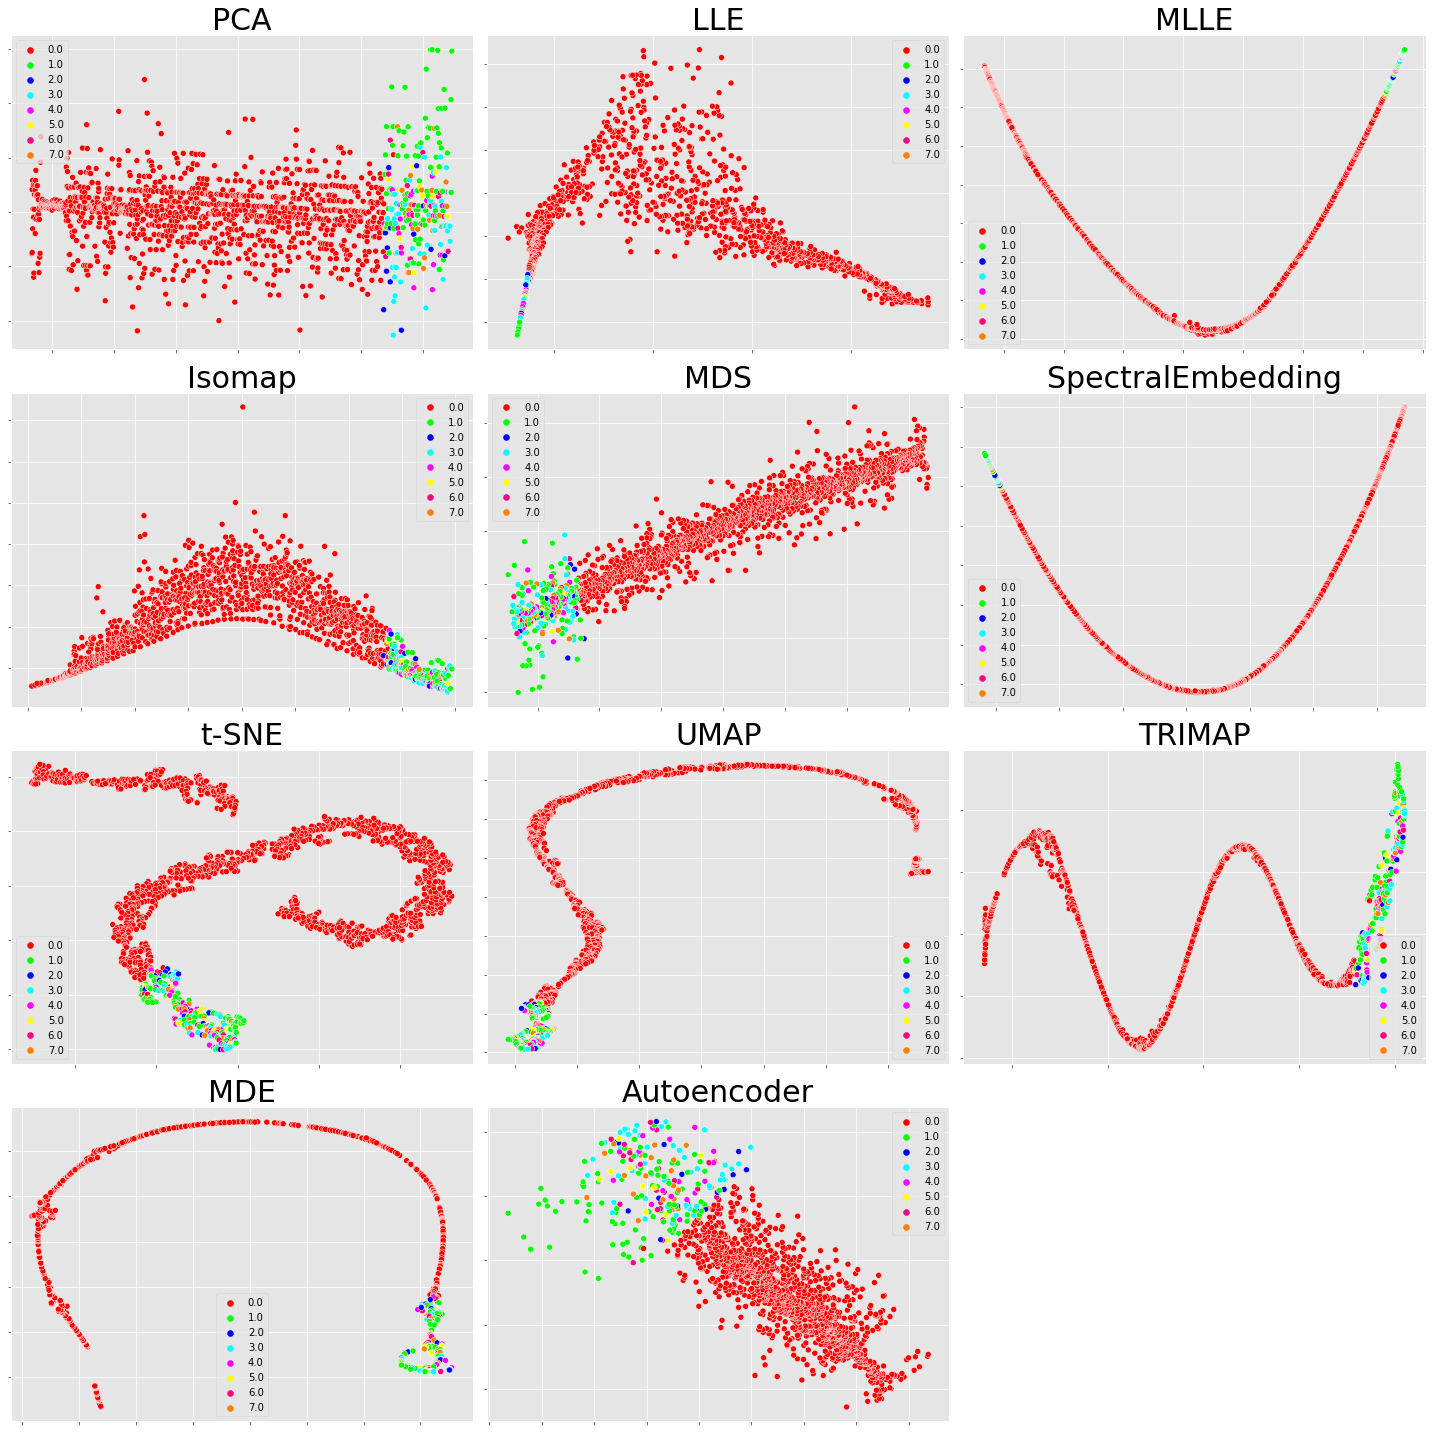